pip install torch numpy pandas matplotlib yfinance ta

In [ ]:
pip install torch numpy pandas matplotlib yfinance ta

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import yfinance as yf
import ta
from itertools import count
import matplotlib.pyplot as plt
import matplotlib.dates
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from importlib.metadata import version
version('tqdm')

'4.66.2'

In [ ]:
def preprocess_data(ticker, start, end):
    # Download stock data
    data = yf.download(ticker, start=start, end=end)

    # Calculate indicators
    data['SMA'] = ta.trend.sma_indicator(data['Close'], window=20)
    data['EMA'] = ta.trend.ema_indicator(data['Close'], window=20)
    data['MACD'] = ta.trend.macd_diff(data['Close'])
    data['RSI'] = ta.momentum.rsi(data['Close'])
    data['STOCH'] = ta.momentum.stoch(data['High'], data['Low'], data['Close'])

    # Drop any rows with NaN values
    data.dropna(inplace=True)

    # Initialize scaler
    scaler = MinMaxScaler()

    # List of indicators to scale
    indicators = ['SMA', 'EMA', 'MACD', 'RSI', 'STOCH']

    # Apply scaling
    data[indicators] = scaler.fit_transform(data[indicators])

    return data

In [ ]:
# Download stock data
ticker = "XOM"
start = "2021-01-01"
end = "2023-06-01"
data = preprocess_data(ticker, start, end)

# Split data
training_data = data['2021-01-01':'2023-01-01']
validation_data = data['2023-01-02':'2023-03-01']
predicitve_data = data['2023-03-02':'2023-06-01']


#training_data
predicitve_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,MACD,RSI,STOCH
Date,,,,,,,,,,,
2023-03-02,110.620003,111.699997,110.169998,111.400002,107.551506,10339900,0.954822,0.957451,0.397429,0.372086,0.246933
2023-03-03,110.050003,113.370003,109.949997,112.809998,108.912788,13006700,0.956064,0.958254,0.454264,0.444882,0.434086
2023-03-06,111.989998,113.839996,111.870003,113.809998,109.878250,14347400,0.957478,0.960445,0.512879,0.493089,0.561581
2023-03-07,112.809998,113.169998,111.169998,111.610001,107.754250,11525300,0.957388,0.959205,0.511484,0.381011,0.361384
2023-03-08,111.230003,112.419998,109.070000,109.980003,106.180565,13509800,0.953693,0.955696,0.482967,0.309199,0.159864
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,107.379997,108.510002,106.730003,107.589996,104.774475,16340300,0.882979,0.890029,0.549062,0.373851,0.620505
2023-05-25,105.940002,106.430000,104.709999,105.660004,102.894981,14316500,0.874624,0.886780,0.557518,0.297387,0.403490
2023-05-26,106.470001,106.949997,104.830002,104.970001,102.223038,12370300,0.864624,0.882829,0.554015,0.271642,0.355802


In [ ]:
# Trading Environment
class StockTradingEnv:
    def __init__(self, data, initial_balance=12000):
        self.stock_price_history = data  # pandas DataFrame
        self.initial_balance = initial_balance
        self.n_step = self.stock_price_history.shape[0]
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_share_value = 0
        self.action_history = [None] * self.n_step # Keeps track of actions: 0 - Buy, 1 - Hold, 2 - Sell
        self.account_history = []  # Keeps track of account value over time
        self.current_stock_price = self.stock_price_history.iloc[self.current_step]['Close']

        # DQN Metrics
        self.total_rewards = []
        self.average_rewards = []
        self.cumulative_rewards = []
        return self._get_observation()

    # FETCH DATA FOR CURRENT STEP
    def _get_observation(self):
        obs = self.stock_price_history.iloc[self.current_step][['Close', 'SMA', 'EMA', 'MACD', 'RSI', 'STOCH']].values
        return obs

    # PERFORM ACTION + VALUE UPDATES
    def step(self, action):
        self.current_stock_price = self.stock_price_history.iloc[self.current_step]['Close']
        prev_total_value = self.balance + self.current_stock_price * self.shares_held

        action = self._take_action(action)
        if action != -1:
          self.action_history[self.current_step] = action



        self.current_step += 1
        self.total_share_value = self.shares_held * self.stock_price_history.iloc[self.current_step]['Close']
        self.account_history.append(self.balance + self.total_share_value)

        # FOR DQN
        if action == 2 and self.shares_held <= 0: # Dissuade it from trying to sell withouy having shares to sell
            reward = self.balance + self.total_share_value - prev_total_value - 50
        else:
          reward = self.balance + self.total_share_value - prev_total_value
        self.total_rewards.append(reward)  # Store reward for current step

        done = self.current_step >= self.n_step - 1

        # Sell all stocks if finished
        if done:
          self.balance = self.balance + self.total_share_value
          self.total_share_value = 0

        obs = self._get_observation()

        return obs, reward, done, {}

    def end_episode(self, cumulative_rewards, average_rewards, i):  # called at the end of each episode
        episode_total_reward = sum(self.total_rewards)
        cumulative_rewards[-1] += episode_total_reward
        if i % 10 == 0:
          cumulative_rewards.append(episode_total_reward)
        if len(self.total_rewards) > 0:
            average_rewards.append(np.mean(self.total_rewards))

        self.total_rewards = []  # Clear rewards for a new episode
        return cumulative_rewards, average_rewards

    # BUY SELL AND HOLD DEFINITIONS
    def _take_action(self, action):
        if action == 0:  # Buy
            shares_to_buy = self.balance // self.current_stock_price
            self.shares_held += shares_to_buy
            self.balance -= shares_to_buy * self.current_stock_price
            return action

        elif action == 2:  # Sell
            self.balance += self.shares_held * self.current_stock_price
            self.shares_held = 0
            return action

        # Hold is action == 1 and does nothing

        return -1


    # (FOR USE ON UNSEEN DATA)
    def set_new_data(self, new_data, predictions):
        self.stock_price_history = new_data
        self.n_step = self.stock_price_history.shape[0]
        self.reset()
        self.action_history = predictions

    def simulate_with_predicted_actions(self, predictions):
        for action in predictions:
            _, _, done, _ = self.step(action)
            if done:
                break

    # GRAPH DISPLAYS
    def render(self, type='dqn'):
        dates = matplotlib.dates.date2num(self.stock_price_history.index.to_pydatetime())

        plt.figure(figsize=(15, 5))
        plt.plot_date(dates, self.stock_price_history['Close'], '-', label='Stock Price', color='blue')


        # Extract moments where actions were taken (0: buy, 1: hold, 2: sell)
        buy_dates, buy_prices = [], []
        sell_dates, sell_prices = [], []
        for i, action in enumerate(self.action_history):
            if action is not None:  # Skip the None values
                date = dates[i]
                price = self.stock_price_history.iloc[i]['Close']
                if action == 0:  # Buy
                    buy_dates.append(date)
                    buy_prices.append(price)
                elif action == 2:  # Sell
                    sell_dates.append(date)
                    sell_prices.append(price)

        plt.scatter(buy_dates, buy_prices, color='green', label='Buy', zorder=5)
        plt.scatter(sell_dates, sell_prices, color='red', label='Sell', zorder=5)

        plt.title('Stock Price History with Buy and Sell Actions')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(loc='upper left')
        plt.show()


        plt.figure(figsize=(15, 5))
        plt.plot(self.account_history, label='Account Value')
        plt.title('Account Value and Total Share Value Over Time')
        plt.xlabel('Steps')
        plt.ylabel('Value')
        plt.legend(loc='upper left')
        plt.show()

        print(f'Total Final Balance: {self.balance}')
        print(f'Profit/Loss: {self.balance - self.initial_balance}')

In [ ]:
# DQN Hyperparameters
episodes = 500 # Total number of episodes to train
state_dim = 6  # Number of states
action_dim = 3 # Number of actions (buy, hold, sell)
learning_rate = 0.001
gamma = 0.99 # Discount factor
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update = 10 # Frequency of updating the target network



In [ ]:
class DQN(nn.Module):
    def __init__(self, input_size, action_size=3):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor([s is not None for s in batch.next_state], dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action).squeeze()
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)

    next_state_values = torch.zeros(batch_size)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def select_action(state, epsilon):
    sample = random.random()
    if sample > epsilon:
        with torch.no_grad():
            return policy_net(state).max(dim=1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(action_dim)]], dtype=torch.long)

In [ ]:
# Initialize DQN
policy_net = DQN(input_size=state_dim, action_size=action_dim)
target_net = DQN(input_size=state_dim, action_size=action_dim)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Evaluation mode for target network

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = ReplayMemory(10000)

# Initialize environment
env = StockTradingEnv(data=training_data)

# Initalize evaluation metrics
average_rewards = []
cumulative_rewards = [0]

In [ ]:
# DQN TRAINING LOOP
for i_episode in tqdm(range(episodes), desc="Training Progress", unit="episode"):
    state = env.reset()
    state = np.array(state)
    state = torch.FloatTensor([state]).unsqueeze(0)  # Adjust for correct shape
    for t in count():  # Using count() for potentially infinite loop
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * i_episode / epsilon_decay)
        action = select_action(state, epsilon)

        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward])

        if not done:
            next_state = torch.FloatTensor([next_state]).unsqueeze(0)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Perform one step of the optimization (on the target network)
        state = next_state
        optimize_model()

        if done:
          env.end_episode(cumulative_rewards, average_rewards, i_episode)
          break

    # Update the target network
    if i_episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())


Training Progress: 100%|██████████| 500/500 [13:19<00:00,  1.60s/episode]


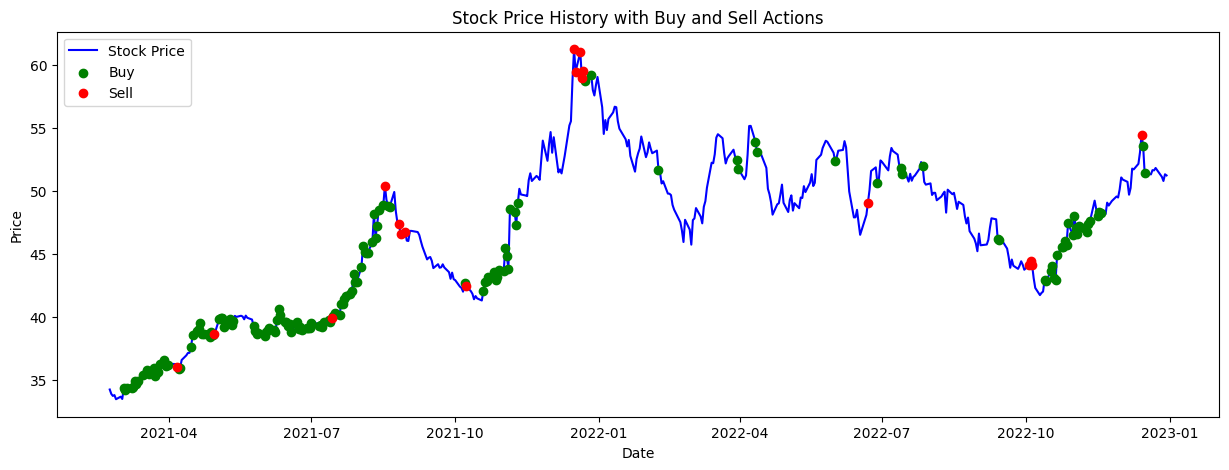

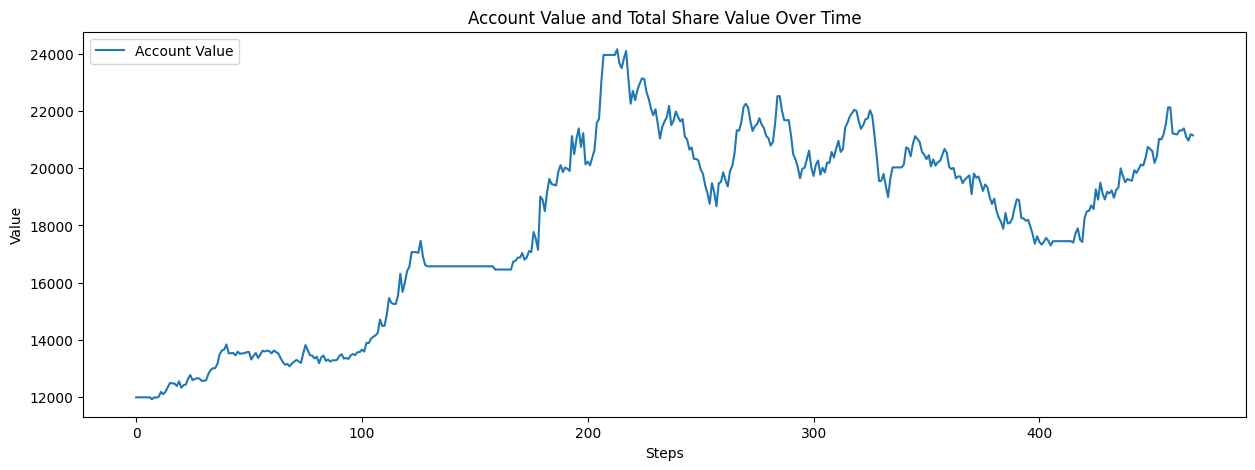

Total Final Balance: 21143.700233459473
Profit/Loss: 9143.700233459473


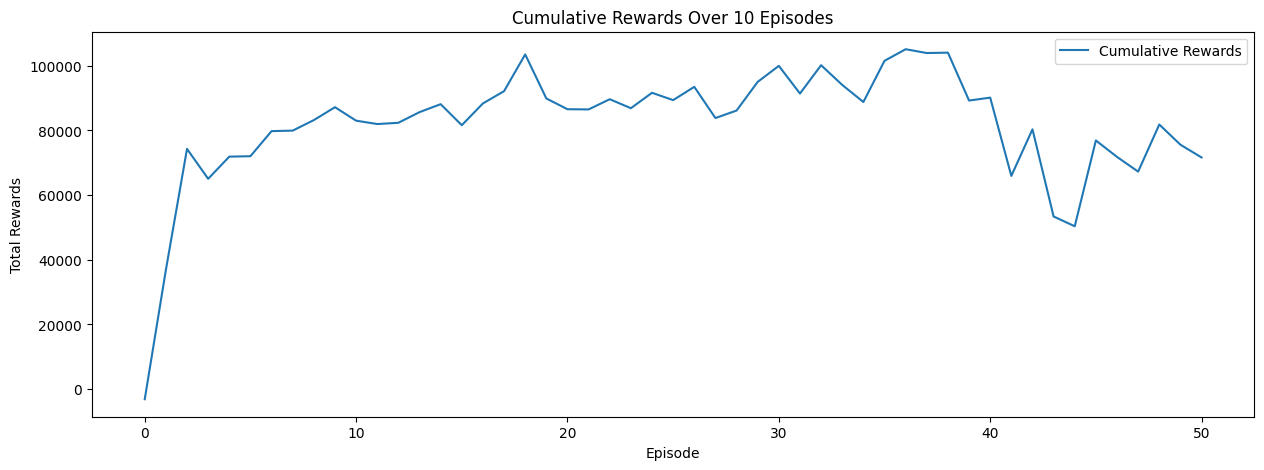

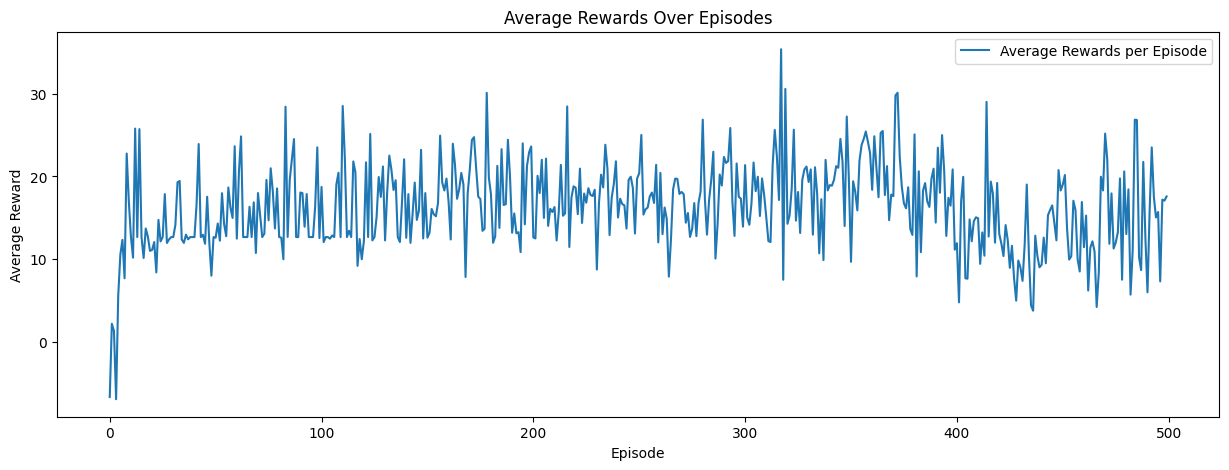

In [ ]:
env.render()


# Graph for Cumulative Rewards
plt.figure(figsize=(15, 5))
plt.plot(cumulative_rewards, label='Cumulative Rewards')
plt.title('Cumulative Rewards Over 10 Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()


# Graph for Average Rewards
plt.figure(figsize=(15, 5))
plt.plot(average_rewards, label='Average Rewards per Episode')
plt.title('Average Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

In [ ]:
def predict_actions(unseen_data, policy_net):
    # Convert preprocessed dataframe to tensor
    states = torch.FloatTensor(unseen_data[['Close', 'SMA', 'EMA', 'MACD', 'RSI', 'STOCH']].values)
    predictions = []

    # Disable gradient computation
    with torch.no_grad():
        for state in states:
            state = state.unsqueeze(0)
            predictions.append(policy_net(state).max(1)[1].item())
    return predictions

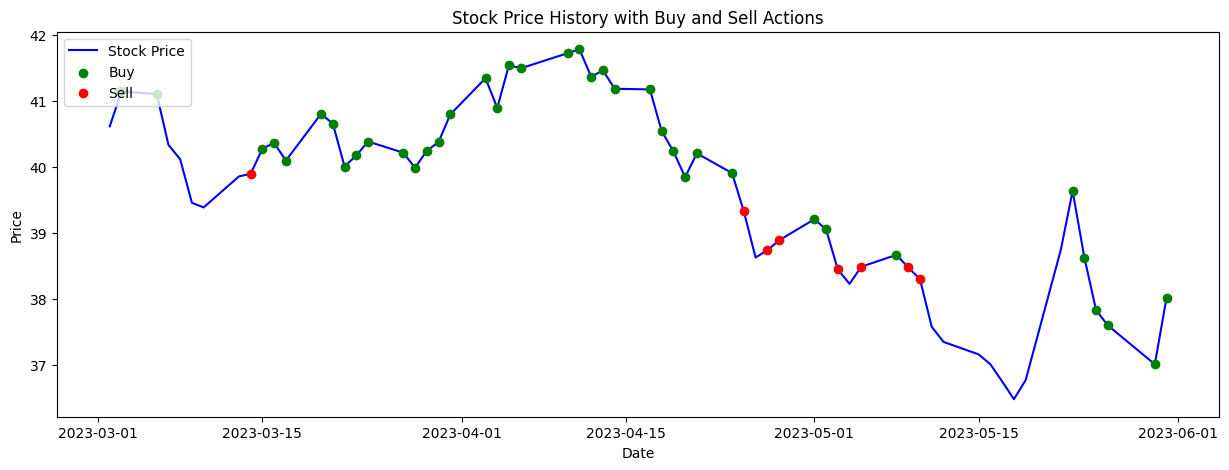

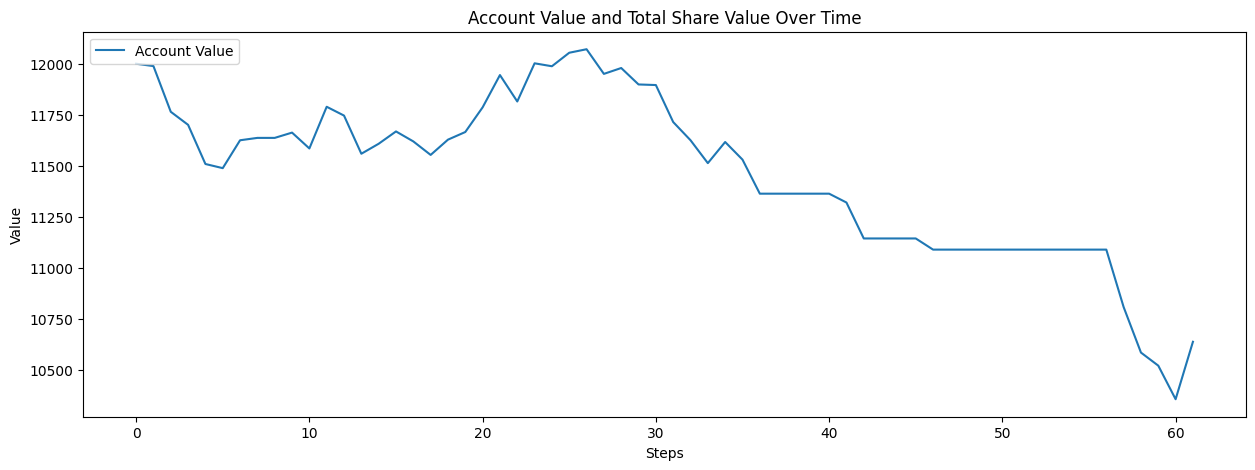

Total Final Balance: 10636.312057495117
Profit/Loss: -1363.6879425048828


In [ ]:
# Use the trained model to predict actions on unseen data
predicted_actions = predict_actions(predicitve_data, policy_net)

# Set the new data and predicted actions to the environment
env.set_new_data(predicitve_data, predicted_actions)

# Simulate the predicted actions being taken in a live scenario
env.simulate_with_predicted_actions(predicted_actions)

# Render environment
env.render()


Epoch 1/10, Loss: 0.2178, Val Loss: 0.1378, MSE: 0.13785813748836517
Epoch 2/10, Loss: 0.2160, Val Loss: 0.1345, MSE: 0.13454808294773102
Epoch 3/10, Loss: 0.2142, Val Loss: 0.1313, MSE: 0.1313094049692154
Epoch 4/10, Loss: 0.2125, Val Loss: 0.1281, MSE: 0.12813739478588104
Epoch 5/10, Loss: 0.2109, Val Loss: 0.1250, MSE: 0.12502680718898773
Epoch 6/10, Loss: 0.2093, Val Loss: 0.1220, MSE: 0.1219724640250206
Epoch 7/10, Loss: 0.2078, Val Loss: 0.1190, MSE: 0.11896957457065582
Epoch 8/10, Loss: 0.2063, Val Loss: 0.1160, MSE: 0.11601362377405167
Epoch 9/10, Loss: 0.2049, Val Loss: 0.1131, MSE: 0.11310051381587982
Epoch 10/10, Loss: 0.2035, Val Loss: 0.1103, MSE: 0.110226571559906
Training complete.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([469, 1, 1])) that is different to the input size (torch.Size([469, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39, 1, 1])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([469, 1, 1])) that is different to the input size (torch.Size([469, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  re

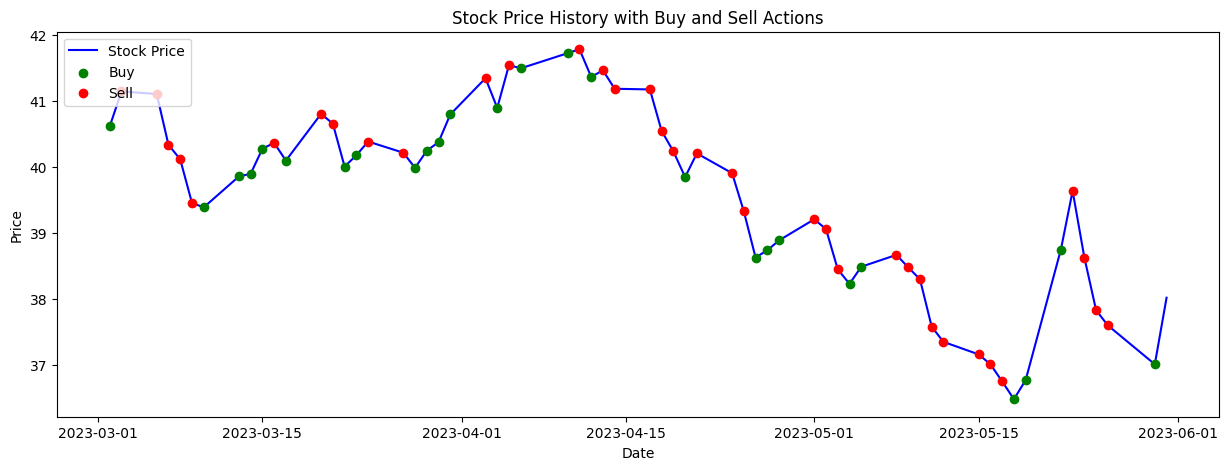

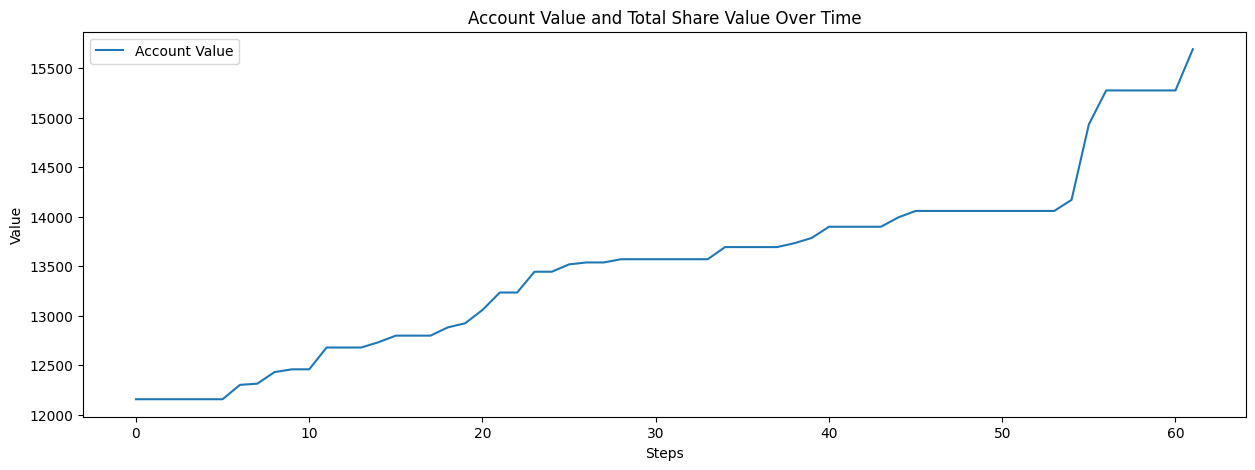

Total Final Balance: 15690.050968170166
Profit/Loss: 3690.050968170166
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Accuracy: 1.0000


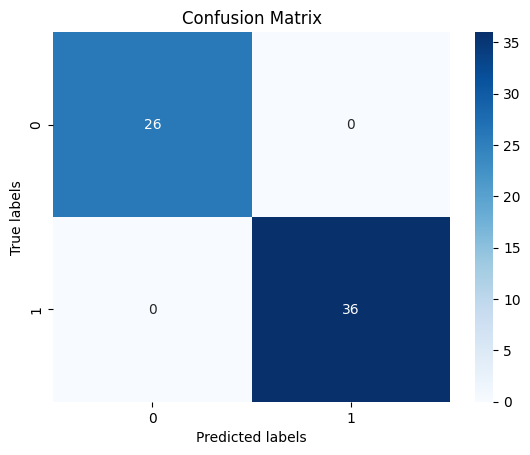

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
import seaborn as sns

class NormalizedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2):
        super(NormalizedLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_normalized_lstm_model(lstm_model, training_data, optimizer, epochs=10):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_training_data = scaler.fit_transform(training_data['Close'].values.reshape(-1, 1))
    scaled_validation_data = scaler.transform(validation_data['Close'].values.reshape(-1, 1))

    # Prepare the data for LSTM: Assume features are the last `batch_size` days of 'Close' values
    train_features = torch.tensor(scaled_training_data[:-1], dtype=torch.float32).unsqueeze(1)
    train_targets = torch.tensor(scaled_training_data[1:], dtype=torch.float32).unsqueeze(1)

    val_features = torch.tensor(scaled_validation_data[:-1], dtype=torch.float32).unsqueeze(1)
    val_targets = torch.tensor(scaled_validation_data[1:], dtype=torch.float32).unsqueeze(1)


    for epoch in range(epochs):
        lstm_model.train()
        optimizer.zero_grad()
        outputs = lstm_model(train_features)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()

        # Validation phase
        lstm_model.eval()
        with torch.no_grad():
            val_outputs = lstm_model(val_features)
            val_loss = criterion(val_outputs, val_targets)

            mse = mean_squared_error(val_targets.view(-1).numpy(), val_outputs.view(-1).numpy())
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, MSE: {mse}')
    print('Training complete.')
    return scaler



def predict_actions_normalized_lstm(unseen_data, lstm_model, scaler):
    lstm_model.eval()
    # Assuming unseen_data is a DataFrame with a 'Close' column
    scaled_data = scaler.transform(unseen_data['Close'].values.reshape(-1, 1))  # This is 2D: [data_points, 1]
    scaled_data = torch.FloatTensor(scaled_data)  # Convert to tensor, maintaining 2D shape

    # Ensure input is 3D: [batch, seq_len, features]. Here, seq_len is assumed to be 1 for single-step prediction
    scaled_data = scaled_data.unsqueeze(1)  # Now: [data_points, 1, 1], corrected to 3D

    predictions = []
    with torch.no_grad():
        outputs = lstm_model(scaled_data)
        predicted_prices = outputs.squeeze(-1)  # Squeeze the unnecessary dimension

        for i in range(len(predicted_prices) - 1):
            current_price = predicted_prices[i]
            next_price = predicted_prices[i + 1]

            # Buying/selling logic based on price prediction
            if next_price > current_price:
                predictions.append(0)  # Buy
            elif next_price < current_price:
                predictions.append(2)  # Sell
            else:
                predictions.append(1)  # Hold

    # Generate true labels based on actual data
    true_labels = []
    prices = unseen_data['Close'].values
    for i in range(1, len(prices)):
        if prices[i] > prices[i - 1]:
            true_labels.append(0)  # Buy
        elif prices[i] < prices[i - 1]:
            true_labels.append(2)  # Sell
        else:
            true_labels.append(1)  # Hold

    # Calculating metrics
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    fscore = f1_score(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)

    return predictions, true_labels, precision, recall, accuracy, fscore


# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()



# Hyperparameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1
learning_rate = 0.001
epochs = 10

# Initialize LSTM model, loss, and optimizer
normalized_lstm_model = NormalizedLSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(normalized_lstm_model.parameters(), lr=learning_rate)

# Train model
fitted_scaler = train_normalized_lstm_model(normalized_lstm_model, training_data, optimizer, epochs)

# Normalize predictive_data using the same scaler as the training data (assumed done within the function for simplicity)
predicted_actions, true_labels, precision, recall, accuracy, fscore= predict_actions_normalized_lstm(predicitve_data, normalized_lstm_model, fitted_scaler)

# Reset environment, set new data and predictions, and show results
env.set_new_data(predicitve_data, predicted_actions)
env.simulate_with_predicted_actions(predicted_actions)
env.render(type='lstm')
"""print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {fscore:.4f}")
print(f"Accuracy: {accuracy:.4f}")
plot_confusion_matrix(true_labels, predicted_actions, classes=["Buy","Sell","Hold"])"""